# Dimensionality reduction via PCA and t-SNE

We show an example for dimensionality reduction on single-cell gene expression data. We take a look at two-dimensional representations that we get from applying principal component analysis (PCA) and t-stochastic neighbourhood embedding (t-SNE) to a single-cell RNA-seq data set.

We employ data from Tasic et al. (2016) who investigated gene expression in 1525 single neurons, extracted from the cortices of mice. They reported a set of 104 genes (Figure 3 of Tasic et al.), based on which different subtypes of neurons can be discriminated and a set of 80 neurotransmitter receptor genes (Figure S15 of Tasic et al.), totalling to 184 genes. 

## Workspace setup


As first step, we load all the packages that are needed. If any of the packages that are not in the standard library are missing, install them first. We print the package versions for reproducibility.

In [24]:
using Pkg
using DelimitedFiles
using Statistics

non_stdlib_pkgs = ["Gadfly", "GZip", "XLSX", "DataFrames", "TSne", "Cairo"]
for pkg in setdiff(non_stdlib_pkgs, keys(Pkg.installed()))
    Pkg.add(pkg)
end

using Gadfly
using GZip
using XLSX
using DataFrames
using TSne
using Cairo

pkgstatus = Pkg.installed()
[(pkgname, pkgstatus[pkgname]) for pkgname in non_stdlib_pkgs]

6-element Array{Tuple{String,VersionNumber},1}:
 ("Gadfly", v"1.2.0")     
 ("GZip", v"0.5.1")       
 ("XLSX", v"0.6.0")       
 ("DataFrames", v"0.20.0")
 ("TSne", v"1.2.0")       
 ("Cairo", v"1.0.2")      

## Data preprocessing
The data from Tasic et al. (2016) has been stored in the [Gene expression Omnibus (GEO)](https://www.ncbi.nlm.nih.gov/geo/) under accession number GSE71585. We first download the expression data and the correspoding sample description  sheet from the GEO and remove the samples from the expression data which have been flagged by Tasic et al. (2016) as being of bad quality. Since the samples of bad quality are not contained within the sample description sheet, we can filter the samples of bad quality by comparing the sample IDs in the expression data with the IDs in the sample description sheet.

In [25]:
function downloadcountsandload()
    url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE71585&format=file&file=GSE71585%5FRefSeq%5Fcounts%2Ecsv%2Egz"
    outfile = "gse715858_counts.csv.gz"
    if !isfile(outfile)
        Base.download(url, outfile)
    end
    fh = GZip.open(outfile)
    countdata = readdlm(fh, ',')
    return countdata
end

function phenodata()
    df = DataFrame(XLSX.readtable("nn.4216-S5.xlsx", "Supplementary_Table_3")...)
    rename!(df, [Symbol(replace(string(i), " " => "")) for i = names(df)])
    return df
end

function expressiondata(;countcutoff=10,samplecutoff=20)
    data = downloadcountsandload()
    x = Float64.(data[2:end,2:end])
    genenames = string.(data[2:end,1])
    samplenames = string.(data[1,2:end])
    samplenames = [replace(i,"Nkx2-1"=>"Nkx2.1") for i = samplenames]
    sampleinfo = phenodata()
    annotatedcells = [findall(x->x==i,samplenames)[1] for i = sampleinfo.GEOSampleTitle]
    genebool = [sum(x[i,:] .> countcutoff)>samplecutoff for i = 1:size(x)[1]]
    xout = x[genebool,annotatedcells]
    genenames = genenames[genebool]
    return xout,genenames,sampleinfo
end

x, genenames, sampleinfo = expressiondata();

Now we can take a look at the data. We have the dat set `x` which contains the estimated number of aligned reads per gene. Since the quantification of aligned reads per gene has been conducted with RSEM [Li et al. 2011], counts per gene represent an estimate which reflects the length of sequenced reads as well as their estimated quality and sequence. Thereby the quantification of expression levels from the sequencing data is becoming more accurate, compared with employing the plain numbers of aligned reads per gene. As a consequence of the estimation procedure, decimal places are allowed and might show up in the estimated counts per gene. We remove genes which are expressed with less than 10 aligned reads in less than 20 samples. This is necessary since many genes are usually expressed only in a single cell and consequently these genes do not substantially represent the structure in the data.

In [26]:
x

15119×1679 Array{Float64,2}:
   992.0    2287.02   491.78   1932.0   …     4.0      2.08   2966.0 
     2.57    177.0      0.0       1.0        12.0    115.0       2.0 
     0.0       0.0      0.0       0.0         0.0      0.0       0.0 
     0.0       0.0      0.0       0.0         0.0   1014.0       0.0 
     0.0     816.0     84.0    1662.18      713.0   1301.0    2381.52
     0.0       0.0      0.0       0.0   …     0.0      0.0       0.0 
     1.0       0.0    169.0    1163.41      200.0    244.0      74.0 
   614.04    612.78   711.11   1746.17      688.47   271.01    411.99
     0.0       0.0      0.0       0.0         0.0      0.0       0.0 
  2028.99      0.0      0.0       0.0       657.95     0.0    1067.46
    50.22      3.37    25.27    878.63  …    26.4      0.0       5.53
  1238.0       0.0      0.0       1.0        49.0     22.0    1710.64
     1.0     285.95     0.0     593.99        0.0      0.0     567.0 
     ⋮                                  ⋱                    

We also have the corresponding gene names.

In [27]:
genenames

15119-element Array{String,1}:
 "0610007C21Rik"
 "0610007L01Rik"
 "0610007N19Rik"
 "0610007P08Rik"
 "0610007P14Rik"
 "0610007P22Rik"
 "0610009B22Rik"
 "0610009D07Rik"
 "0610009L18Rik"
 "0610009O20Rik"
 "0610010B08Rik"
 "0610010F05Rik"
 "0610010K14Rik"
 ⋮              
 "mt_BC012020"  
 "mt_BC020072"  
 "mt_BC020382"  
 "mt_BC055066"  
 "mt_BC069931"  
 "mt_BC071253"  
 "mt_BC081549"  
 "mt_BC104337"  
 "mt_BC128309"  
 "mt_GU332589"  
 "mt_X57779"    
 "mt_X57780"    

The sample description sheet indicates for each sample the cell ID ("CellID") the cell type ("PrimaryType") as well as multiple quality control indices, such as the number of aligend reads ("TotalReads") or the percentage of mRNA ("mRNA").

In [28]:
show(describe(sampleinfo), allcols = true)

20×8 DataFrame
│ Row │ variable                  │ mean      │ min                      │
│     │ Symbol                    │ Union…    │ Any                      │
├─────┼───────────────────────────┼───────────┼──────────────────────────┤
│ 1   │ Cell#                     │ 840.0     │ 1                        │
│ 2   │ CellID                    │           │ A01101401                │
│ 3   │ ShortID                   │           │ A1602_V                  │
│ 4   │ Cre                       │           │ Calb2                    │
│ 5   │ FACStdTomato*             │           │ N                        │
│ 6   │ MajorDissection           │           │ V1                       │
│ 7   │ LayerDissection           │           │ All                      │
│ 8   │ CoreType                  │           │ Core                     │
│ 9   │ PrimaryType               │           │ Astro Aqp4               │
│ 10  │ SecondaryType             │           │ Igtp                     │
│ 11  │ To

### Normalization

After loading the data, we can now proceed to prepare the data for modeling. We normalize the single-cell data set for sequencing depth using an algorithm from DESeq (Anders and Huber, 2010) and then log-transform the expression data. Afterwards we standardize the data. Normalization for sequencing depth is important since the number of aligned reads per sample fluctuate which affects the estimated expression level for each gene. The algorithm of Anders and Huber (2010) calculates correction factors, one for each sequencing library, i.e. sample, by which the sequencing data are divided. We can study the effect of normalization by comparing the distribution of aligned reads in the sequencing libraries before and after normalization.

The function `estimatesizefactorsformatrix` is a Julia implementation of the function `estimateSizeFactorsForMatrix` from the DESeq Bioconductor R package (V1.38.0).

In [29]:
function estimatesizefactorsformatrix(mat; locfunc=median)
    logcounts = log.(mat)
    loggeomeans = vec(mean(logcounts, dims=2))
    finiteloggeomeans = isfinite.(loggeomeans)
    loggeomeans = loggeomeans[finiteloggeomeans]
    logcounts = logcounts[finiteloggeomeans,:]
    nsamples = size(logcounts, 2)
    size_factors = fill(0.0, nsamples)
    for i = 1:nsamples
        size_factors[i] = exp(locfunc(logcounts[:,i] .- loggeomeans))
    end
    return size_factors
end

function normalizecountdata(mat)
    sizefactors = estimatesizefactorsformatrix(mat)
    return mat ./ sizefactors'
end

xnorm = normalizecountdata(x);

After normalization, we can inspect the effect of the normalization for sequencing depth by comparing the distribution of log transformed counts in different samples in the non-normalized and normalized data. Here, for demonstration purposes we randomly pick 20 samples.

In [30]:
using Random
Random.seed!(2134)
selectedsamples = Random.randperm(size(x)[2])[1:20]
## Non-normalized data
df1 = DataFrame(Expression=cat(dims=1,[log.(x[:,i] .+1) for i = selectedsamples]...),Sample=cat(dims=1,[fill(string(i),size(x)[1]) for i = selectedsamples]...));
## Normalized data
df2 = DataFrame(Expression=cat(dims=1,[log.(xnorm[:,i] .+1) for i = selectedsamples]...),Sample=cat(dims=1,[fill(string(i),size(xnorm)[1]) for i = selectedsamples]...));


First we inspect the non-normalized data ...

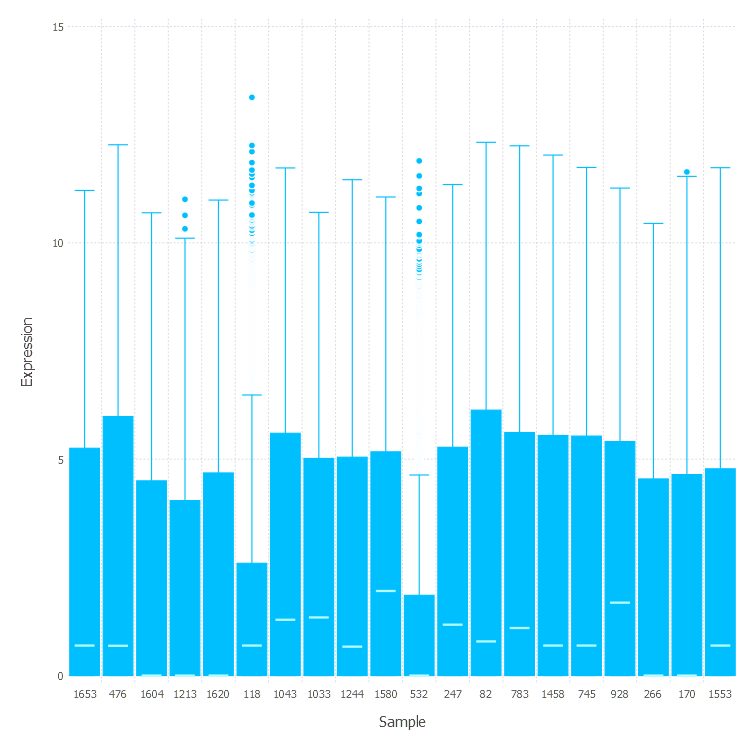

In [31]:
draw(PNG(20cm, 20cm), plot(df1, x = "Sample", y = "Expression", Geom.boxplot));

... and we compare it with the normalized data. The normalization procedure adjusts the count distribution in each sample while this cannot fully achieved for sample 118 and 532 which differ to a large extent from the other samples.

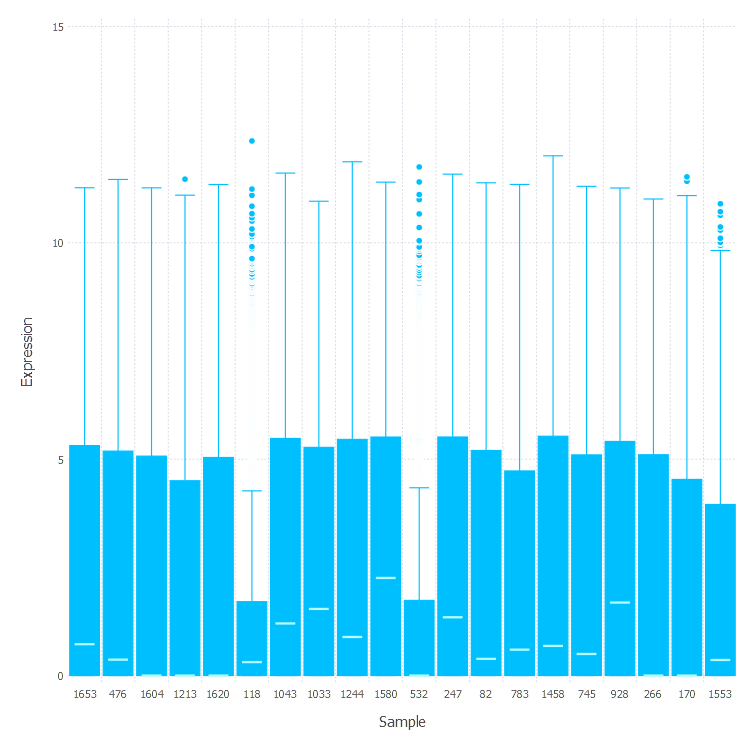

In [32]:
draw(PNG(20cm, 20cm),plot(df2, x = "Sample", y = "Expression", Geom.boxplot));

### Selecting samples and genes for further inspection

Our samples so far contain expression levels of over 15.119 genes in 1679 samples. We now investigate how the different cells differ in gene expression. To lower computational demands we decided to employ a set of genes from Tasic et al. (2016) from whom the data emerged. The benefit here is that we a priori know the genes which carry a biologically interpretable signal. 

We load the Markergenes which are known to indicate cell type membership ([Figure 3](https://www.nature.com/articles/nn.4216/figures/3) in Tasic et al. (2016)) ... 


In [33]:
markergenes = readdlm("gene_subtypes.csv", ';')[2:end,1];

... and the neurotransmitter receptorgenes which are differentially expressed in different neuron cell types but have a less pronounced expression pattern (supplementary material, [Figure S 15](https://static-content.springer.com/esm/art%3A10.1038%2Fnn.4216/MediaObjects/41593_2016_BFnn4216_MOESM67_ESM.pdf))

In [34]:
receptorgenes = [i  for i = readdlm("S15.txt")[:,2:end][:] if i!="" ];

We create a vector which indicates the cell type:

In [35]:
celltype = [split(i)[1] for i = sampleinfo.PrimaryType];

We select the neural cell types, remove non-neural cells from the `celltype` vector.

In [36]:
NonNeural = ["Astro Aqp4","OPC Pdgfra","Oligo 96*Rik","Oligo Opalin","Micro Ctss","Endo Xdh","SMC Myl9"];
neuralcells = [!(i in NonNeural) for i = sampleinfo.PrimaryType];
celltype = celltype[neuralcells]

1525-element Array{SubString{String},1}:
 "Vip"  
 "Vip"  
 "L4"   
 "Vip"  
 "Vip"  
 "L2/3" 
 "L2"   
 "L2/3" 
 "L4"   
 "L2"   
 "Pvalb"
 "L2/3" 
 "Vip"  
 ⋮      
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Vip"  
 "Vip"  
 "Vip"  
 "Vip"  
 "Vip"  
 "Vip"  

Finally we select the expression data for receptor and marker genes in neural cells.

In [37]:
receptorandmarkers = [i in union(receptorgenes,markergenes) for i = genenames]
xnorm_sel = xnorm[receptorandmarkers,neuralcells];
genenames_sel = genenames[receptorandmarkers];

The matrix `xnorm_sel` contains the expression levels of 180 marker and receptor genes in 1525 neural cells:

In [38]:
size(xnorm_sel)

(180, 1525)

## Principal component analysis (PCA)
For performing PCA, we compute the first two principal components from the data. By default, we standardize the data before performing PCA.

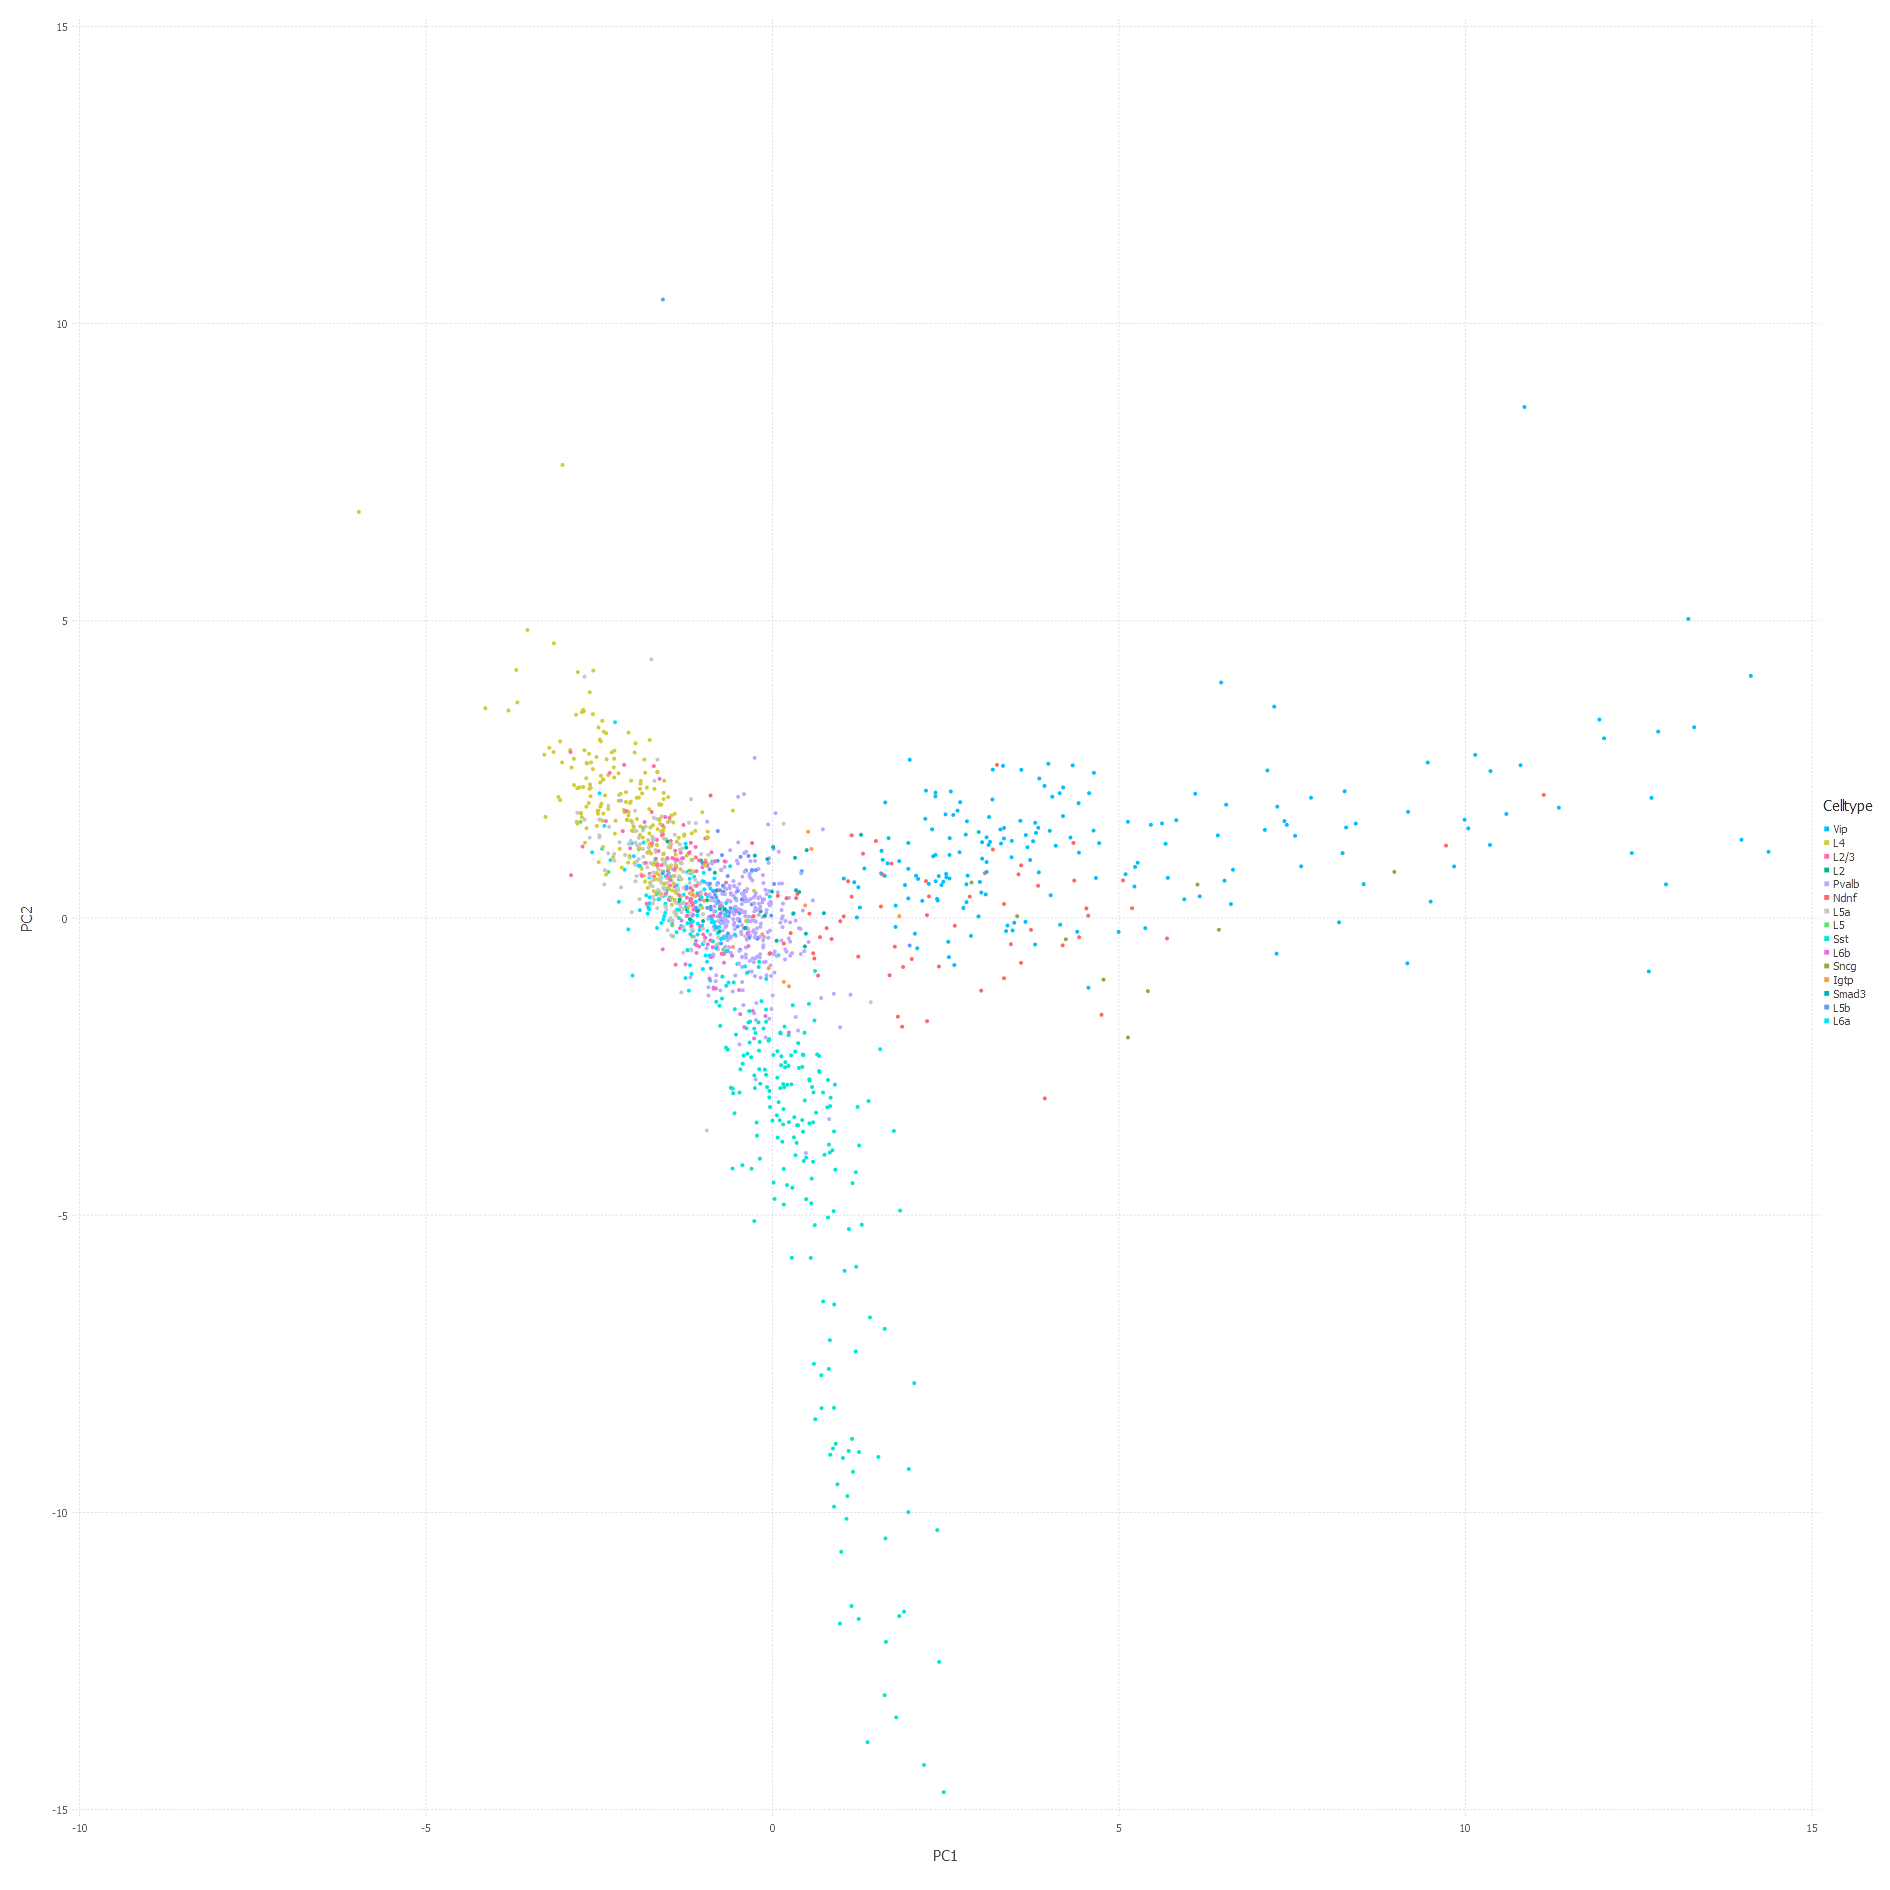

In [39]:
using Statistics
function standardize(x)
    (x .- mean(x, dims = 1)) ./ std(x, dims = 1)
end

using LinearAlgebra
function prcomps(mat, standardizeinput = true)
    if standardizeinput
        mat = standardize(mat)
    end
    u,s,v = svd(mat)
    prcomps = u * Diagonal(s)
    return prcomps
end

mat = xnorm_sel'
subtype = celltype
pcaout = prcomps(mat);


plotdata = DataFrame(PC1 = pcaout[:,1], PC2 = pcaout[:,2], Celltype = subtype);
draw(PNG(50cm, 50cm),plot(plotdata, x=:PC1, y=:PC2, color=:Celltype, 
    Theme(highlight_width = 0pt, point_size = 1.5pt),
    Coord.Cartesian(ymin=-15, ymax=15, xmin=-10, xmax=15)));

If you would like to examine the plots more closely, you can switch cell types on and off by clicking at the plots' legend.

## t-SNE

The t-SNE hyperparameters we used are:
* 2 as number of dimensions
* 50 dimensions as initial dimension reduction via PCA
* 1000 iterations
* perplexity 20.0.


In [40]:
using TSne
tsneout = tsne(mat, 2, 50, 1000, 20.0; progress = false);

To evaluate the hyperparameters of t-SNE, we can take a range of possible hyperparameters and visualize the dimensionality reduction. For this we can use the convenient parallel processing features of Julia:

In [41]:
using Distributed
addprocs(Sys.CPU_THREADS - nprocs() + 1)
@everywhere using TSne
@everywhere using DataFrames
@eval @everywhere mat = $mat
@eval @everywhere subtype = $subtype
@everywhere function tsne_mat(pcadim_perplexity)
   tsneout = tsne(mat, 2, 50, 1000, 20.0; progress = false)
   DataFrame(tSNE1 = tsneout[:, 1], tSNE2 = tsneout[:, 2],
         pcadim = pcadim_perplexity[1], perplexity = pcadim_perplexity[2],
         Celltype = subtype)
end
@time tsnedf = vcat(map(tsne_mat, Iterators.product(50:50:200, float.(20:10:50)))...);

111.560779 seconds (165.17 k allocations: 1.491 GiB, 0.25% gc time)


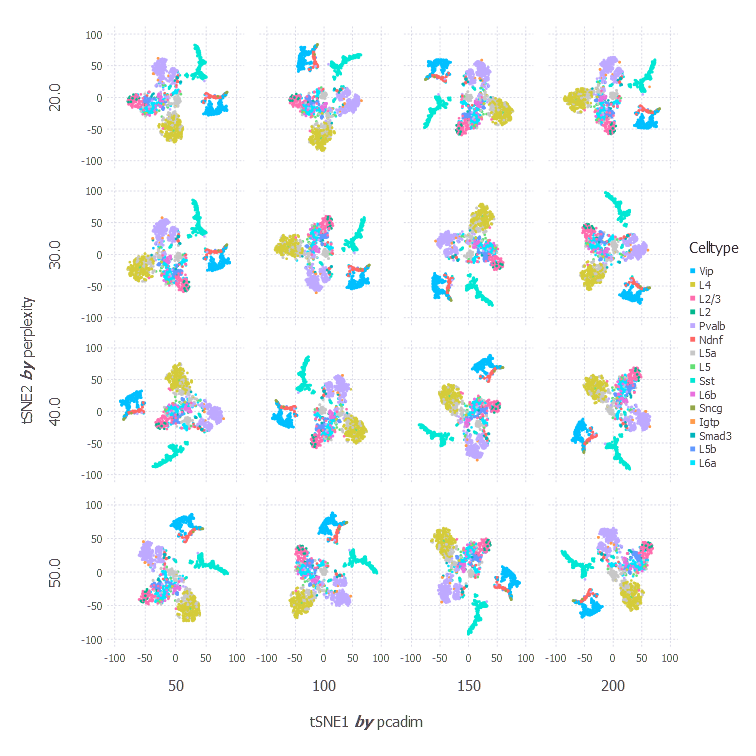

In [42]:
draw(PNG(20cm, 20cm), plot(tsnedf,
      xgroup = "pcadim", ygroup = "perplexity", x = "tSNE1", y = "tSNE2", color = "Celltype",
      Geom.subplot_grid(Geom.point), Theme(highlight_width = 0pt, point_size = 1pt)));

### Conclusion

The different cell types cluster together in the PCA. The separation of different cell types is much better with t-SNE compared to the results from the PCA.

The clusters allow to infer the differences in expression between different cell types.

## Literature

Tasic, B., V. Menon, T. N. Nguyen, T. K. Kim, T. Jarsky, Z. Yao, B. Levi, L. T. Gray, S. A. Sorensen, T. Dolbeare, et al. (2016). *Adult mouse cortical cell taxonomy revealed by single cell transcriptomics*. Nature neuroscience 19(2), 335.

Anders, S., & Huber, W. (2010). *Differential expression analysis for sequence count data*. Genome biology, 11(10), R106.

L.J.P. van der Maaten and G.E. Hinton. *Visualizing High-Dimensional Data Using t-SNE*. Journal of Machine Learning Research 9(Nov):2579-2605, 2008.

 B Li, and  C.N. Dewey,   RSEM:  accurate  transcript  quantification  from  RNA-Seq data with or without a reference genome. BMC Bioinformatics12, 323 (2011).